*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


In [12]:
import os
import pickle
import numpy as np

from gensim.models import KeyedVectors

import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import umap


PYTORCH_PKL = "word2vec_embeddings.pkl"
GENSIM_TEXT8_PKL = "word2vec_gensim_embeddings.pkl"

GOOGLE_NEWS_MODEL = "word2vec-google-news-300.model"
FASTTEXT_MODEL = "fasttext-wiki-news-subwords-300.model"


def load_pkl_embeddings(path: str):
    
    with open(path, "rb") as f:
        data = pickle.load(f)

    E = data["embeddings"]
    word2idx = data["word2idx"]
    idx2word = data["idx2word"]

    if isinstance(idx2word, list):
        idx2word = {i: w for i, w in enumerate(idx2word)}

    E = np.asarray(E)
    return E, word2idx, idx2word


class EmbeddingSource:
    def __init__(self, name, dim, get_vec_fn):
        self.name = name
        self.dim = dim
        self.get_vec = get_vec_fn


def make_pkl_source(name: str, pkl_path: str) -> EmbeddingSource:
    E, word2idx, idx2word = load_pkl_embeddings(pkl_path)
    dim = E.shape[1]

    def _get_vec(word: str):
        idx = word2idx.get(word)
        if idx is None:
            return None
        return E[idx]

    return EmbeddingSource(name=name, dim=dim, get_vec_fn=_get_vec)


def make_keyedvectors_source(name: str, model_path: str) -> EmbeddingSource:
    kv = KeyedVectors.load(model_path, mmap="r")
    dim = kv.vector_size

    def _get_vec(word: str):
        try:
            return kv.get_vector(word)
        except KeyError:
            return None

    src = EmbeddingSource(name=name, dim=dim, get_vec_fn=_get_vec)
    src.kv = kv
    return src


pytorch_src = make_pkl_source("PyTorch Skip-Gram (100d)", PYTORCH_PKL)
gensim_text8_src = make_pkl_source("Gensim Word2Vec Text8 (100d)", GENSIM_TEXT8_PKL)

google_news_src = make_keyedvectors_source("Pretrained Word2Vec Google News (300d)", GOOGLE_NEWS_MODEL)
fasttext_src = make_keyedvectors_source("Pretrained FastText Wiki Subwords (300d)", FASTTEXT_MODEL)

sources = [pytorch_src, gensim_text8_src, google_news_src, fasttext_src]

print("Loaded sources:")
for s in sources:
    print(f" - {s.name}: dim={s.dim}")


Loaded sources:
 - PyTorch Skip-Gram (100d): dim=100
 - Gensim Word2Vec Text8 (100d): dim=100
 - Pretrained Word2Vec Google News (300d): dim=300
 - Pretrained FastText Wiki Subwords (300d): dim=300


In [14]:
nltk.download("punkt")
nltk.download("punkt_tab")

def tokenize_text(text):
    return word_tokenize(text.lower())

def sentence_embedding(text: str, src: EmbeddingSource):
    tokens = tokenize_text(text)
    vecs = [src.get_vec(tok) for tok in tokens]
    vecs = [v for v in vecs if v is not None]
    if len(vecs) == 0:
        return None, 0, tokens
    mat = np.stack(vecs, axis=0)
    return mat.mean(axis=0), len(vecs), tokens

def cosine_sim(a, b):
    # safe cosine
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


sentences = ["The cat sat on the mat.", "A dog is playing in the yard.",
    "I need to buy groceries today.", "The feline was resting on the rug.", "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

query = "My pet cat is sleeping on the carpet."


for src in sources:
    print("\n" + "="*80)
    print(src.name)

    q_vec, q_used, q_tokens = sentence_embedding(query, src)
    print(f"Query tokens: {q_tokens}")
    print(f"Query in-vocab tokens used: {q_used}/{len(q_tokens)}")

    if q_vec is None:
        print("No tokens found in vocab for query; skipping.")
        continue

    sims = []
    for s in sentences:
        s_vec, s_used, s_tokens = sentence_embedding(s, src)
        if s_vec is None:
            sim = float("nan")
        else:
            sim = cosine_sim(q_vec, s_vec)
        sims.append((sim, s, s_used, len(s_tokens)))

    # sort high->low, keep NaNs at bottom
    sims_sorted = sorted(sims, key=lambda x: (-(x[0]) if not np.isnan(x[0]) else 1e9))

    for sim, sent, used, total in sims_sorted:
        print(f"{sim: .4f}  | used {used}/{total} | {sent}")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nolanwhite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nolanwhite/nltk_data...



PyTorch Skip-Gram (100d)
Query tokens: ['my', 'pet', 'cat', 'is', 'sleeping', 'on', 'the', 'carpet', '.']
Query in-vocab tokens used: 8/9
 0.8821  | used 6/7 | The cat sat on the mat.
 0.7738  | used 7/8 | The feline was resting on the rug.
 0.7330  | used 7/8 | A dog is playing in the yard.
 0.7067  | used 5/6 | The weather is beautiful today.
 0.6919  | used 7/8 | My shopping list includes milk and bread.
 0.6282  | used 6/7 | I need to buy groceries today.
 0.6131  | used 4/5 | Programming requires logical thinking.
 0.5795  | used 4/5 | Canines enjoy outdoor activities.

Gensim Word2Vec Text8 (100d)
Query tokens: ['my', 'pet', 'cat', 'is', 'sleeping', 'on', 'the', 'carpet', '.']
Query in-vocab tokens used: 7/9
 0.7016  | used 6/7 | The cat sat on the mat.
 0.5818  | used 7/8 | A dog is playing in the yard.
 0.4843  | used 5/6 | The weather is beautiful today.
 0.4731  | used 5/8 | The feline was resting on the rug.
 0.4727  | used 7/8 | My shopping list includes milk and bread.
 0

[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


The output above reports the sentence similarities, the number of words within each sentence that are contained in the vocabulary of each of the four models, and also prints the corresponding sentence. For clearer comparison, the sentences with the highest cosine similarities are printed first.

**Overall, each of the four sets of embeddings did a pretty good job ordering the sentences by similarity to the query sentence. Each model picked between two highly similar sentences "The feline was resting on teh rug." and "The cat sat on the mat" as the top two most similar sentences. However, the sentences each model interpreted as the least similar varied a bit more. "Canines enjoy outdoor activities.", "Programming requires logical thinking.", and "I need to buy groceries today." were the three sentences at the bottom of at least one model. I initially thought a possible explanaiton could be that some models embed canine and feline as opposite, while others captured their similarity. However, the skip-gram presents evidence against this, since that model ranks the sentence about "canines" at the bottom - even though cat and canine might tend to appear in similar contexts. 

We can see that the FastText model had the highest similarity scores across the board, capturing well the semantic similarity between feline and cat, and the related canine words. Entirely unrelated sentences had the least similar scores. With the largest vocabulary, embeddings for each word were available. Together with subword modeling, this might explain why its similarity scores were clearly the highest.

Gensim had the largest range in similarity scores, but the sentences with notably low similarity scores had more out-of-vocabulary words.**


PyTorch Skip-Gram (100d)
  animals kept: 16/16
  foods kept:   16/16


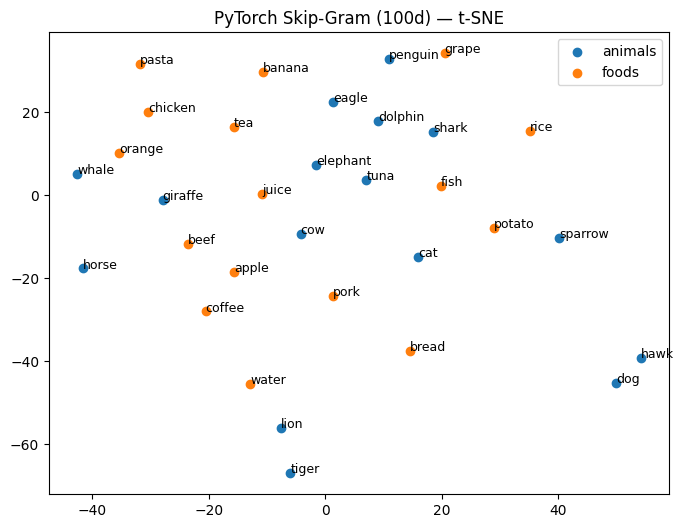

/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


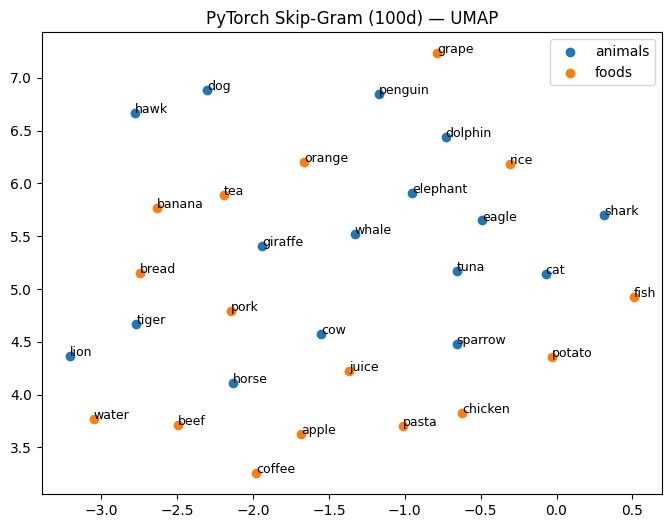


Gensim Word2Vec Text8 (100d)
  animals kept: 16/16
  foods kept:   16/16


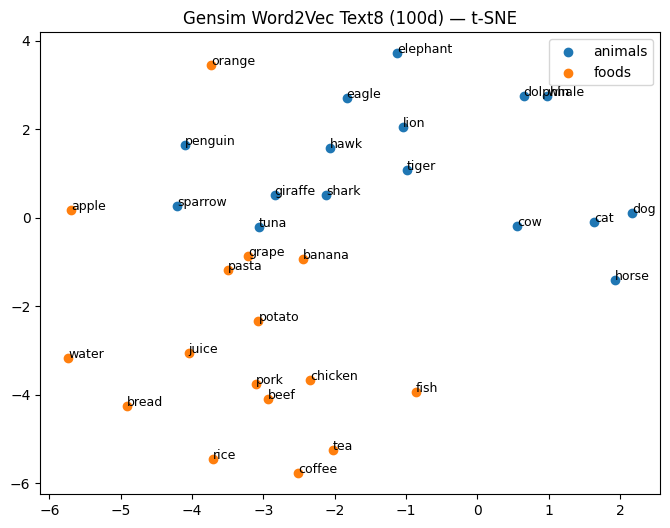

/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


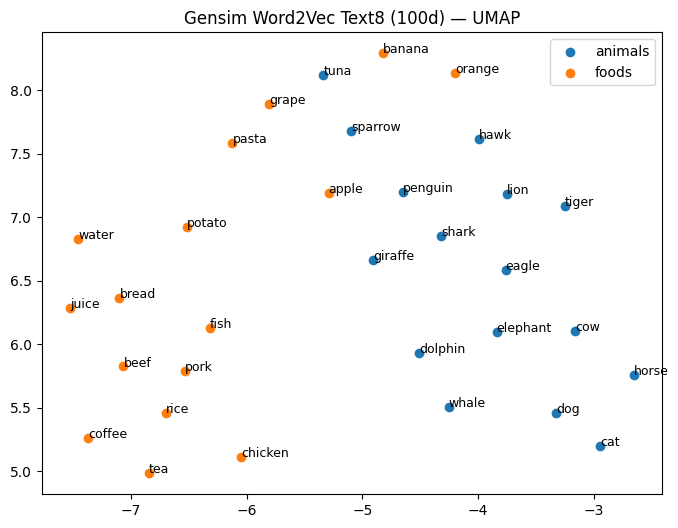


Pretrained Word2Vec Google News (300d)
  animals kept: 16/16
  foods kept:   16/16


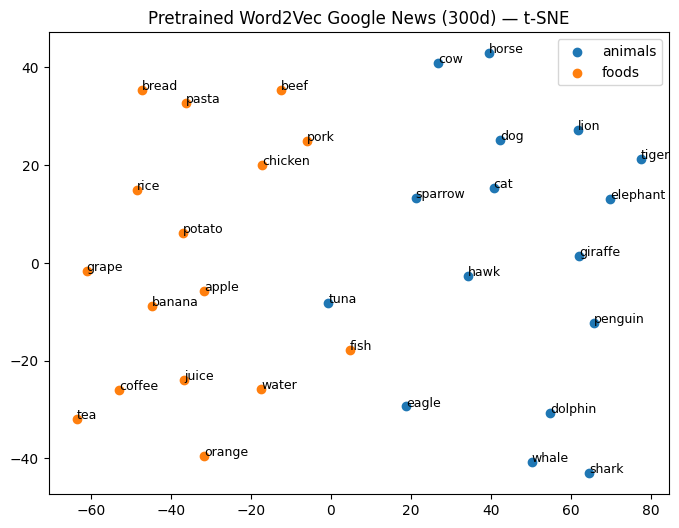

/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


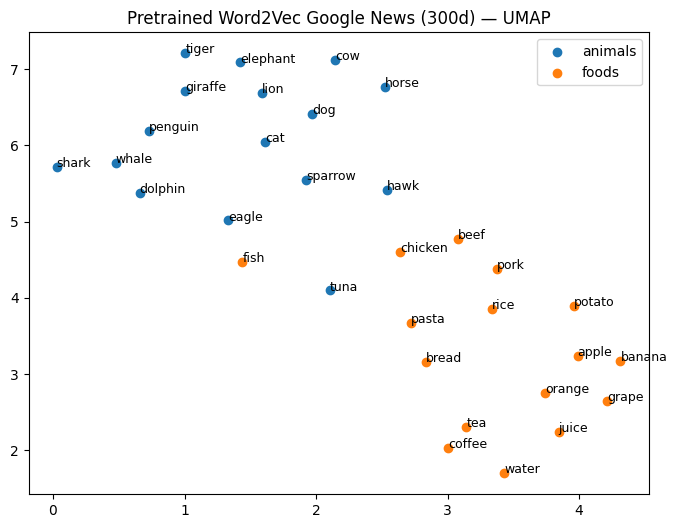


Pretrained FastText Wiki Subwords (300d)
  animals kept: 16/16
  foods kept:   16/16


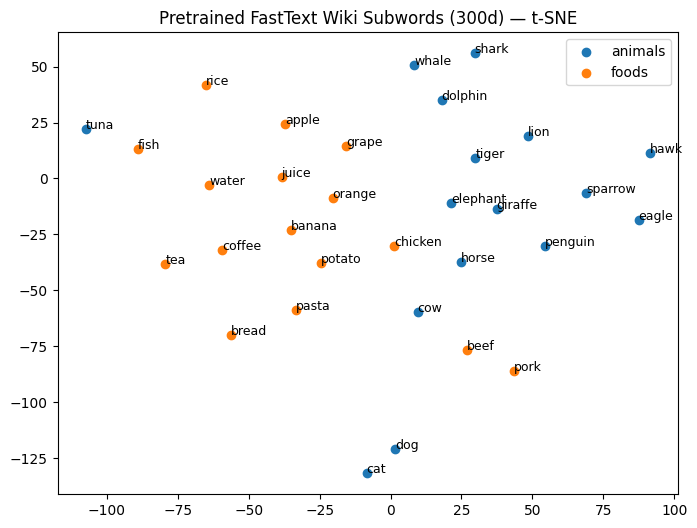

/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nolanwhite/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


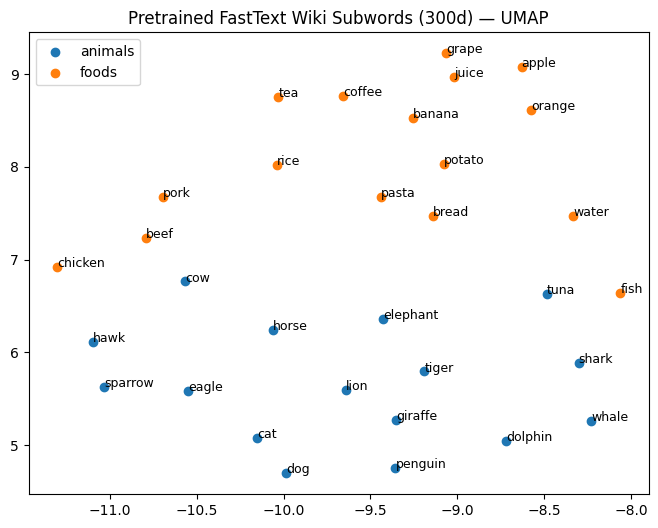

In [ ]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

def collect_vectors(words, src: EmbeddingSource):
    kept_words = []
    vecs = []
    for w in words:
        v = src.get_vec(w)
        if v is not None:
            kept_words.append(w)
            vecs.append(v)
    if len(vecs) == 0:
        return [], None
    return kept_words, np.stack(vecs, axis=0)

def plot_2d(points2d, labels, groups, title):
    plt.figure(figsize=(8, 6))
    for g in sorted(set(groups)):
        idx = [i for i, gg in enumerate(groups) if gg == g]
        plt.scatter(points2d[idx, 0], points2d[idx, 1], label=g)
        for i in idx:
            plt.text(points2d[i, 0], points2d[i, 1], labels[i], fontsize=9)
    plt.title(title)
    plt.legend()
    plt.show()

def run_tsne(X, seed=42):
    tsne = TSNE(n_components=2, random_state=seed, init="random", perplexity=10)
    return tsne.fit_transform(X)

def run_umap(X, seed=42):
    reducer = umap.UMAP(n_components=2, random_state=seed, n_neighbors=10, min_dist=0.2)
    return reducer.fit_transform(X)

for src in sources:
    a_words, A = collect_vectors(animals, src)
    f_words, F = collect_vectors(foods, src)

    if A is None or F is None:
        print(f"Skipping {src.name}: missing vectors for a category.")
        continue

    labels = a_words + f_words
    X = np.vstack([A, F])
    groups = (["animals"] * len(a_words)) + (["foods"] * len(f_words))

    print(f"\n{src.name}")
    print(f"Animals kept: {len(a_words)}/{len(animals)}")
    print(f"Foods kept:   {len(f_words)}/{len(foods)}")

    X_tsne = run_tsne(X)
    plot_2d(X_tsne, labels, groups, title=f"{src.name} — t-SNE")

    X_umap = run_umap(X)
    plot_2d(X_umap, labels, groups, title=f"{src.name} — UMAP")


## Short Answer Questions

1. Which embeddings performed best at capturing sentence meaning?


The output above (from the cell above the embedding visualization plots) reports the sentence similarities, the number of words within each sentence that are contained in the vocabulary of each of the four models, and also prints the corresponding sentence. For clearer comparison, the sentences with the highest cosine similarities are printed first.

**Overall, each of the four sets of embeddings did a pretty good job ordering the sentences by similarity to the query sentence. Each model picked between two highly similar sentences "The feline was resting on teh rug." and "The cat sat on the mat" as the top two most similar sentences. However, the sentences each model interpreted as the least similar varied a bit more. "Canines enjoy outdoor activities.", "Programming requires logical thinking.", and "I need to buy groceries today." were the three sentences at the bottom of at least one model. I initially thought a possible explanaiton could be that some models embed canine and feline as opposite, while others captured their similarity. However, the skip-gram presents evidence against this, since that model ranks the sentence about "canines" at the bottom - even though cat and canine might tend to appear in similar contexts. 

We can see that the FastText model had the highest similarity scores across the board, capturing well the semantic similarity between feline and cat, and the related canine words. Entirely unrelated sentences had the least similar scores. With the largest vocabulary, embeddings for each word were available. Together with subword modeling, this might explain why its similarity scores were clearly the highest.

Gensim had the largest range in similarity scores, but the sentences with notably low similarity scores had more out-of-vocabulary words.**


2. Were the pretrained embeddings significantly better than your own? Why or why not?

From my analysis, the sentence similarity analysis did not show a really significant improvement from my embeddings to the pretrained ones. However, some of the shortcomings of my model are exposed in the UMAP and tSNE embedding visualizations immediately above. There is both a UMAP and tSNE plot for each of the four sets of embeddings: PyTorch SkipGram, the provided Gensim Word2Vec, Pretrained Word2Vec, and Pretrained FastText. It is evident that while there is some logical grouping and clustering in the embedding visualizations for my PyTorch Skip-Gram model, the three other models performed significantly better than my embeddings. Although my skip gram model did not separate well the food and animal categories in the embedding space, similar words can still be found frequently near adjacent words: "lion" and "tiger" are close to each other, as are "tuna", "shark" and "dolphin". 

It makes sense that the sentence similarity scores don't reveal the differences as well--the similarity scores were averages, which might smooth out model differences, and ultimately are a coarse evaluation metric. 

The provided and pretrained embeddings better differentiated between food and animal and had more natural semantic clustering. For example in the FastText UMAP plot, there is a reasonable grouping of land animals "cow", "horse", "hawk", "cat" etc. and sea animals "whale", "shark", "dolphin" etc. Moreover, words like "chicken" that could be classified as both a food and animal is right on the boundary between the groups. "Fish" is near "tuna", and "beef" is near "cow", each properly categorized.


3. What factors might explain this difference?

Several factors might explain performence differences across the embedding sets. 

The pretrained models were trained on much larger and more diverse text than the Text8 dataset for the custom embeddings. This would likely make them more generalizable and reliable for semantic analysis.

The higher dimensionality of the pretrained models (300 vs. 100 of the custom models) likely gave the pretrained models more space to embed semantic meaning into its word vectors, while the models with lower dimensionality were forced to output noiser embeddings.

FastText includes subword information which produces much denser semantic clusters. My skip-gram model was limited in size and vocabulary, resulting in the opposite effects.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>


I used ChatGPT (5.2 for the most part) to debug and draft code, mostly to make syntax more concise and to help with the class constructing lines where I have signficantly less coding experience. Also used AI to teach me how to use new libraries.

I read the helper scripts, analyzed the plots, formatted output, and produced all of markdown text by myself.